# **Imports**
First of all, we import all the libraries and functions that we will use throughout the notebook.

In [1]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow

from tensorflow import keras 
from keras import models
from keras import applications
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# **Data loading**

We read the training data, test data and sample submissions.

In [2]:
train  = pd.read_csv('../input/digit-recognizer/train.csv')
test   = pd.read_csv('../input/digit-recognizer/test.csv')
sample = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

X = np.array(train.iloc[:, 1:])
Y = np.array(train.iloc[:, 0])
test = test.to_numpy()

n = X.shape[0]
m = X.shape[1]

print("Number of training samples: ", n)
print ("Number of features: ", m)

Number of training samples:  42000
Number of features:  784


# **Data display**

Let's see some randomly selected images from the dataset.

                                                                   Random examples                                                                    


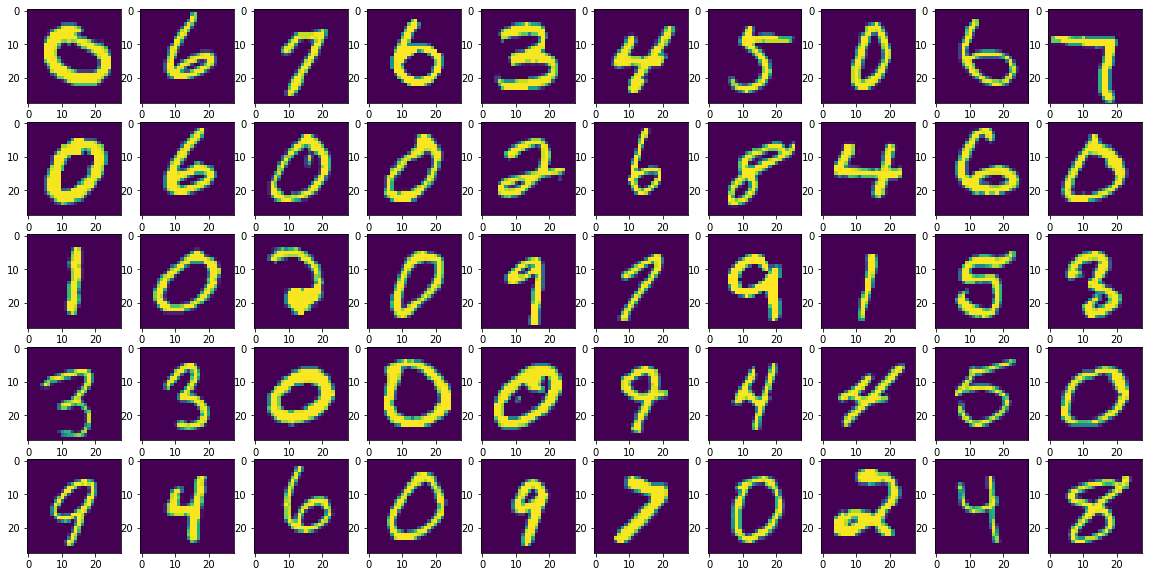

In [3]:
index = np.random.randint(0, n, 50)
plt.figure(figsize = (20, 10))
for i, idx in enumerate(index):
    plt.subplot(5, 10, i+1)
    plt.imshow(np.resize(X[idx], (28, 28, 1)))
print("Random examples".center(150))   
plt.show()

We show the number of examples of each label. As you can see the training data is balanced.

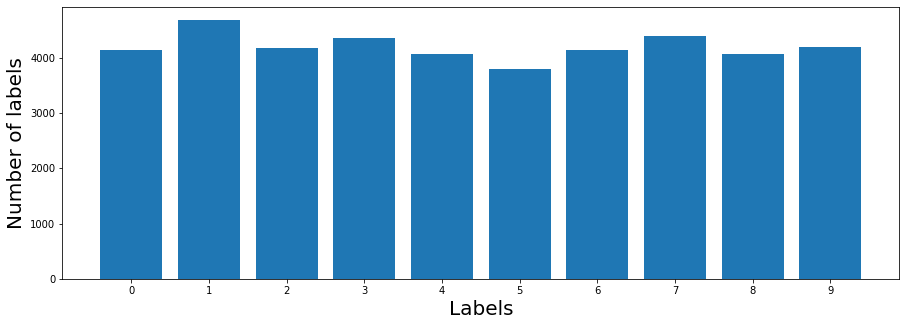

In [4]:
x_labels = sorted(list(set(Y)))
y_labels = [Y.tolist().count(i) for i in x_labels]

plt.figure(figsize = (15,5))
plt.ylabel('Number of labels',  fontsize=20)
plt.xlabel('Labels',  fontsize=20)
plt.xticks([i for i in range(len(x_labels))]) 
plt.bar(x_labels, y_labels)
plt.show()

# **Data preprocessing**

In order to train a neural network we perform the following normalizations and transformations:

* Resize the images to $28 \times 28 \times 1$, which will be the input of our neural network.
* Transform the output $Y$ class following a one-hot encoding, becouse we are facing a classification problem with multiple classes.
* Normalize the training data dividing by the maximun value of the features ($255$).

## Resize the images

In [5]:
print('Dimensions of training data before resizing data: ', X.shape, '\n')
print('Dimensions of test data before resizing data: ', test.shape, '\n')

X = np.reshape(X, (X.shape[0], 28, 28, 1))
test = np.reshape(test, (test.shape[0], 28, 28, 1))

print('Dimensions of training data after resizing data: ', X.shape)
print('Dimensions of test data after resizing data: ', test.shape)

Dimensions of training data before resizing data:  (42000, 784) 

Dimensions of test data before resizing data:  (28000, 784) 

Dimensions of training data after resizing data:  (42000, 28, 28, 1)
Dimensions of test data after resizing data:  (28000, 28, 28, 1)


## One-hot encoding

In [6]:
print('Example output before one-hot encoding: ', Y[0], '\n')

Y = to_categorical(Y)

print('Example output after one-hot encoding: ', Y[0])

Example output before one-hot encoding:  1 

Example output after one-hot encoding:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Normalize the training data

In [7]:
print('Minimum value of the features before normalization: ', np.min(X))
print('Maximum value of features before normalization: ', np.max(X), '\n')

X = X / 255.0
test = test / 255.0

print('Minimum value of the features before normalization: ', np.min(X))
print('Maximum value of features before normalization: ', np.max(X))

Minimum value of the features before normalization:  0
Maximum value of features before normalization:  255 

Minimum value of the features before normalization:  0.0
Maximum value of features before normalization:  1.0


# Division of data into train and test

We will split the train set into two new sets $p$ and $v$ . Basically, we will use the train set $p$ to train the model and the validation set $v$ to estimate the hyperparameters (number of iterations, etc). The train set was divided into $80\%$ for $p$ and $20\%$ for $v$.

In [8]:
indexs = np.arange(n)
posicion = int(n * 0.8)

X_train_p = X[indexs[:posicion]]
X_train_v = X[indexs[posicion:]] 
Y_train_p = Y[indexs[:posicion]]
Y_train_v = Y[indexs[posicion:]]

print(X_train_v.shape)
print("Number of examples of X_train_p: ", X_train_p.shape[0])
print("Number of examples of X_train_v: ", X_train_v.shape[0])

(8400, 28, 28, 1)
Number of examples of X_train_p:  33600
Number of examples of X_train_v:  8400


# Data Aumentation

We apply **Data Augmentation**. For this we will perform some transformations on the images:
* rotation,
* zoom.
* horizontal displacements.
* vertical displacements.

In [9]:
data_gen = ImageDataGenerator(validation_split = 0.2, rotation_range = 10, zoom_range = 0.1, width_shift_range = 0.1, height_shift_range = 0.1)

# **Model training**

In order to improve the classification rate we will use an **Ensemble Method**. This technique creates multiple models and combines them to produce improved results. Ensemble methods often produce more accurate solutions than single model solutions. Therefore we will use $7$ models (we will use the <A href="https://www.kaggle.com/ruddyguerreroalvarez/digit-recognizer-cnn?scriptVersionId=90124014">CNN architecture</A> that has given us the best score $0.99482$ so far). Each model will make its prediction and the top voted class will be the predicted one.


In [10]:
# Create the model
n_models = 7
model = [0] * n_models
inputs = Input(shape = (28, 28, 1))
for i in range(n_models):
    model[i] = Conv2D(32, kernel_size  = (5, 5), padding = 'same', activation = 'relu')(inputs)
    model[i] = BatchNormalization()(model[i])
    model[i] = Conv2D(64, kernel_size  = (5, 5), padding = 'same',activation = 'relu')(model[i])
    model[i] = BatchNormalization()(model[i])
    model[i] = MaxPooling2D(pool_size  = (2, 2))(model[i])
    model[i] = Dropout(0.5)(model[i])
    model[i] = Conv2D(128, kernel_size = (5, 5), padding = 'same', activation = 'relu')(model[i])
    model[i] = BatchNormalization()(model[i])
    model[i] = Conv2D(128, kernel_size = (5, 5), padding = 'same', activation = 'relu')(model[i])
    model[i] = BatchNormalization()(model[i])
    model[i] = MaxPooling2D(pool_size  = (2, 2))(model[i])
    model[i] = Dropout(0.5)(model[i])
    model[i] = Conv2D(256, kernel_size = (5, 5), padding = 'same', activation = 'relu')(model[i])
    model[i] = BatchNormalization()(model[i])
    model[i] = Conv2D(256, kernel_size = (5, 5), padding = 'same', activation = 'relu')(model[i])
    model[i] = Flatten()(model[i])

    model[i] = Dropout(0.5)(model[i])
    model[i] = Dense(512, activation = 'relu')(model[i])
    model[i] = BatchNormalization()(model[i])
    model[i] = Dropout(0.5)(model[i])
    model[i] = Dense(10, activation   = 'softmax')(model[i])

2022-03-16 12:04:34.096598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 12:04:34.235789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 12:04:34.236924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 12:04:34.238769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

To mitigate overtraining we apply **Early Stopping**.

In [11]:
for i in range(n_models):
    model[i] = Model(inputs = inputs, outputs = model[i])
    model[i].compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=30,verbose=1)
]

We show the summary of one of the models.

In [12]:
model[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0     

We start the training of the network. We specify the training sets and the number of iterations. We will save all the information in the history variable $h$ so that later we can plot the obtained result.

In [13]:
h = [0] * n_models
for i in range(n_models): 
    data_train = data_gen.flow(X_train_p, Y_train_p, shuffle = True, subset = 'training', batch_size = 32)
    h[i] = model[i].fit(data_train, validation_data = (X_train_v, Y_train_v), batch_size = 64, epochs = 500, callbacks = callbacks_list)

2022-03-16 12:04:38.531154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-03-16 12:04:41.097782: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


840/840 [==============================] - 27s 21ms/step - loss: 0.3555 - accuracy: 0.8920 - val_loss: 0.0888 - val_accuracy: 0.9730

Epoch 00001: val_loss improved from inf to 0.08880, saving model to model.h5
Epoch 2/500
840/840 [==============================] - 18s 21ms/step - loss: 0.1179 - accuracy: 0.9645 - val_loss: 0.0583 - val_accuracy: 0.9817

Epoch 00002: val_loss improved from 0.08880 to 0.05830, saving model to model.h5
Epoch 3/500
840/840 [==============================] - 19s 22ms/step - loss: 0.0921 - accuracy: 0.9731 - val_loss: 0.0397 - val_accuracy: 0.9889

Epoch 00003: val_loss improved from 0.05830 to 0.03974, saving model to model.h5
Epoch 4/500
840/840 [==============================] - 18s 21ms/step - loss: 0.0785 - accuracy: 0.9767 - val_loss: 0.0438 - val_accuracy: 0.9886

Epoch 00004: val_loss did not improve from 0.03974
Epoch 5/500
840/840 [==============================] - 19s 22ms/step - loss: 0.0740 - accuracy: 0.9782 - val_loss: 0.0367 - val_accuracy: 

We show the history of the behavior for the cost function in the training and validation sets for one model.

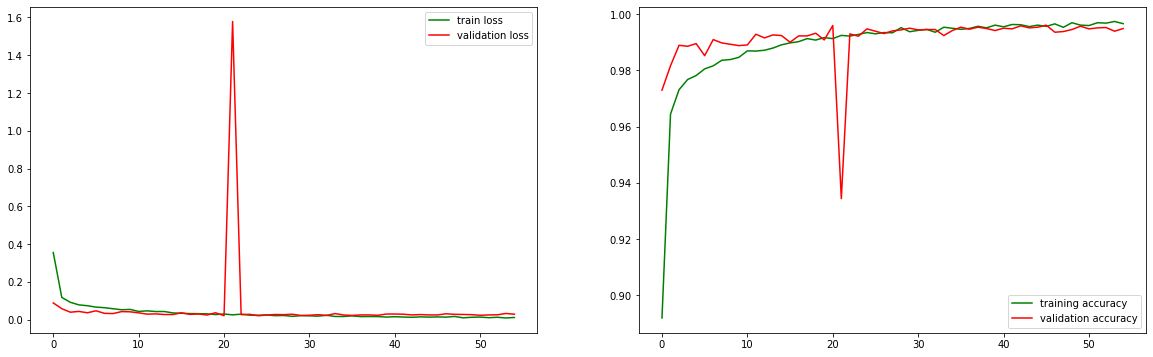

In [14]:
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(h[0].history['loss'], 'g', label = 'train loss')
plt.plot(h[0].history['val_loss'], 'r', label = 'validation loss')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(h[0].history['accuracy'], 'g', label = 'training accuracy')
plt.plot(h[0].history['val_accuracy'], 'r', label = 'validation accuracy')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

# **Classification of test examples**
Then we classify the test examples. We chose the class **most voted** by the $7$ models.

In [15]:
result = np.zeros((test.shape[0], 10))
for j in range(n_models):
    result = result + model[j].predict(test)
sample.iloc[:,1] = result.argmax(axis = 1)

Finally, we save the classified examples

In [16]:
sample.to_csv('./submission.csv', index = False)